In [38]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.set_printoptions(precision=4)
np.random.seed(0)

In [3]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

x_train = X.T
y_train = np.eye(len(set(y)))[y]
y_train = y_train.T

In [19]:
class Layer:
    def __init__(self) -> None:
        pass
           
    def forward(self, input_data):
        raise NotImplementedError
    
    def backward(self, grad, alpha):
        raise NotImplementedError
        
class ZLayer(Layer):
    def __init__(self, inSize, outSize):
        np.random.seed(0)
        self.W = 0.01 * np.random.randn(outSize, inSize)
        self.B = 0.0 * np.random.randn(outSize, 1)
        
    def forward(self, inData):
        self.input = inData
        self.output = np.dot(self.W, self.input) + self.B
        return self.output
        
    def backward(self, outGrad, alpha=1e-0):
        inGrad = np.dot(self.W.T, outGrad)
        dW = np.dot(outGrad, self.input.T) # /self.input.shape[1]
        dB = np.sum(outGrad, axis=1, keepdims=True)
        self.dW = dW
        self.dB = dB
        self.W -= alpha * dW
        self.B -= alpha * dB
        return inGrad        
    
class ALayer(Layer):
    def __init__(self, g, gPrime):
        self.g = g
        self.gPrime = gPrime

    def forward(self, inData):
        self.input = inData
        self.output = self.g(self.input)
        return self.output

    def backward(self, outGrad):
        return self.gPrime(self.input) * outGrad

class SLayer(ALayer):
    def backward(self, outGrad):
        #return np.einsum('ijk,ik->ij', self.gPrime(self.output), outGrad)
        return np.einsum('jik,kj->ij', self.gPrime(self.output), outGrad)
    
class LLayer(Layer):
    def __init__(self, g, gPrime, eps=1e-8):
        self.g = g
        self.gPrime = gPrime
        self.eps = eps

    def forward(self, pred, obs):
        self.input = pred
        self.output = self.g(pred, obs, self.eps)
        return self.output

    def backward(self, pred, obs):
        return self.gPrime(pred, obs, self.eps)    

In [20]:
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

def mse(y_obs, y_pred):
    return np.mean(np.power(y_obs - y_pred, 2));

def mse_prime(y_obs, y_pred):
    return 2*(y_pred - y_obs) / y_obs.size;

def softmax(x):
    tmp = np.exp(x)
    return tmp / np.sum(tmp, axis=0, keepdims=True)

def softmax_prime(x):
    # X(n,m) : matrix of softmax probabilities, #n classes, #m samples 
    i = np.eye(x.shape[0])               # Identity matrix with n dimensions
    tmp1 = np.einsum('ij,ik->jik', x, i)  # Matrix of diagolized softmax values (per m)
    tmp2 = np.einsum('ij,kj->jik', x, x)  # Matrix of cross product of softmax values (per m)
    return tmp1 - tmp2 

def centropy(x, y, eps=1e-8):
    #nobs = pred.shape[1]
    #correct_logp = -np.log(pred[obs, range(nobs)])
    #return np.sum(correct_logp) / nobs
    x = x.clip(min=eps, max=None)
    logp = np.where(y==1, -np.log(x), 0)
    return logp.sum(axis=0)

def centropy_prime(x, y, eps=1e-8):
    x = x.clip(min=eps, max=None)
    return np.where(y==1, -1/x, 0)


In [6]:
Z1 = ZLayer(2, 3)
Z1.forward(x_train)

A1 = SLayer(softmax, softmax_prime)
A1.forward(Z1.output)

L1 = LLayer(centropy, centropy_prime)
L1.forward(A1.output, y_train)

grad_ce = L1.backward(A1.output, y_train)
grad_sm = A1.backward(grad_ce)/grad_ce.shape[1]
grad_dW = Z1.backward(grad_sm)

print('probs.T \n', A1.output[:,0:5].T, A1.output.shape, '\n')
print('y_train.T \n', y_train[:,0:5].T, y_train.shape, '\n')

print('CE \n', L1.output[0:5], L1.output.shape, '\n')
print('loss \n', f"{np.sum(L1.output)/L1.output.shape[0] : .6f} \n")

print('grad_ce.T \n', grad_ce[:,0:5].T, grad_ce.shape, '\n')
print('grad_sm.T \n', grad_sm[:,0:5].T, grad_sm.shape, '\n')

print('dW.T \n', Z1.dW.T, Z1.dW.shape, '\n')
print('dB.T \n', Z1.dB.T, Z1.dB.shape, '\n')
print('W.T \n', Z1.W.T, Z1.W.shape, '\n')
print('B.T \n', Z1.B.T, Z1.B.shape, '\n')

probs.T 
 [[0.3333 0.3333 0.3333]
 [0.3333 0.3334 0.3333]
 [0.3333 0.3334 0.3332]
 [0.3333 0.3334 0.3332]
 [0.3333 0.3335 0.3332]] (3, 300) 

y_train.T 
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]] (3, 300) 

CE 
 [1.0986 1.0986 1.0986 1.0986 1.0986] (300,) 

loss 
  1.097088 

grad_ce.T 
 [[-3.      0.      0.    ]
 [-3.      0.      0.    ]
 [-3.0001  0.      0.    ]
 [-3.      0.      0.    ]
 [-3.      0.      0.    ]] (3, 300) 

grad_sm.T 
 [[-0.0022  0.0011  0.0011]
 [-0.0022  0.0011  0.0011]
 [-0.0022  0.0011  0.0011]
 [-0.0022  0.0011  0.0011]
 [-0.0022  0.0011  0.0011]] (3, 300) 

dW.T 
 [[-0.0402 -0.0504  0.0906]
 [ 0.0838 -0.098   0.0142]] (3, 2) 

dB.T 
 [[-4.5442e-06 -8.1432e-05  8.5976e-05]] (3, 1) 

W.T 
 [[ 0.0579  0.0602 -0.0719]
 [-0.0798  0.1204 -0.0239]] (3, 2) 

B.T 
 [[ 4.5442e-06  8.1432e-05 -8.5976e-05]] (3, 1) 



epoch    0/100   error=1.097088
epoch   10/100   error=0.915790
epoch   20/100   error=0.847933
epoch   30/100   error=0.817080
epoch   40/100   error=0.801040
epoch   50/100   error=0.791919
epoch   60/100   error=0.786398
epoch   70/100   error=0.782901
epoch   80/100   error=0.780609
epoch   90/100   error=0.779067
training accuracy: 0.49


(-1.8712034092398278, 1.8687965907601756)

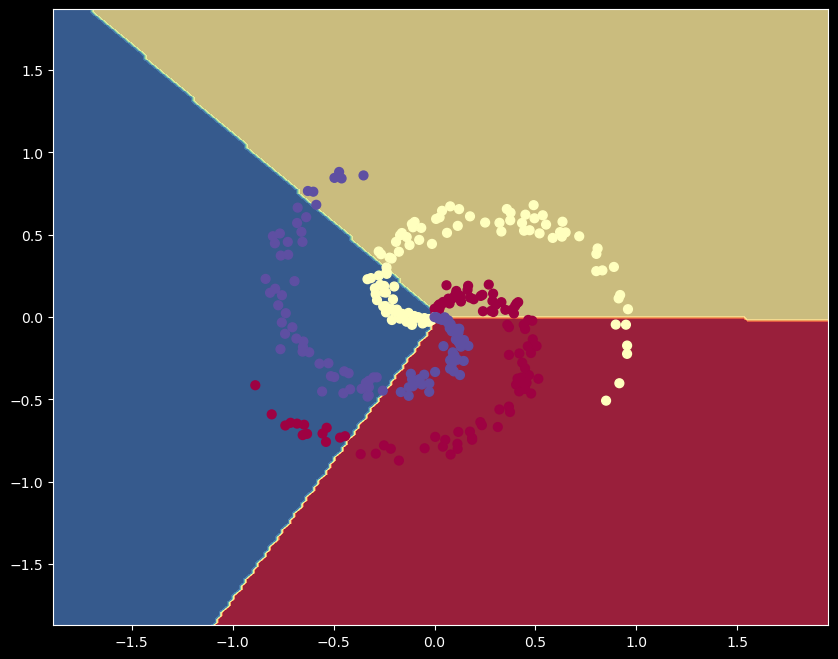

In [39]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        
    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
        
    def fit(self, x_train, y_train, epochs, learning_rate, verbose=False):
        #for i in tqdm(range(epochs)):
        for i in range(epochs):
        #for i in range(epochs):
            output = x_train
            for layer in self.layers:
                output = layer.forward(output)

            err = self.loss(output, y_train)
            err = np.sum(err) / err.shape[0]
            grad = self.loss_prime(output, y_train)
            grad = grad / grad.shape[1]
            for layer in reversed(self.layers):
                grad = layer.backward(grad)
        
            if i % (epochs/10) == 0:
                print('epoch %4.d/%d   error=%f' % (i, epochs, err))


nn = Network()
nn.add(ZLayer(2, 3))
nn.add(SLayer(softmax, softmax_prime))

nn.use(centropy, centropy_prime)

nn.fit(x_train, y_train, 100, 1)

W = nn.layers[0].W
B = nn.layers[0].B
scores = np.dot(W, x_train) + B
predicted_class = np.argmax(scores, axis=0)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

h = 0.02
x_min, x_max = x_train[0, :].min() - 1, x_train[0, :].max() + 1
y_min, y_max = x_train[1, :].min() - 1, x_train[1, :].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W.T) + B.T
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(x_train[0, :], x_train[1, :], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
np.set_printoptions(precision=4)
np.random.seed(0)

x_train = np.array([[0,0], [0,1], [1,0], [1,1]]).T
y_train = np.array([[0], [1], [1], [0]]).T

L1 = FCLayer(2, 3)
L1.forward(x_train)
#print(L1.W)
#print(L1.B)
print(L1.input)
print(L1.output)

A1 = ActivationLayer(tanh, tanh_prime)
A1.forward(L1.output)
print(A1.output)

L2 = FCLayer(3, 1)
L2.forward(A1.output)

A2 = ActivationLayer(tanh, tanh_prime)
A2.forward(L2.output)
print(A2.output)



In [ ]:
import numpy as np
np.set_printoptions(precision=4)
#%matplotlib inline

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

In [ ]:
class Network_:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate, verbose=False):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in tqdm(range(epochs)):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            if verbose:
                print('epoch %d/%d   error=%f' % (i+1, epochs, err))